In [1]:
using Plots
using PlotlyJS
using Statistics
using QuadGK
using MAT

In [2]:
vars_q4 = matread("../solutions/Q4data.mat")
time = vars_q4["time"];
Tout = vars_q4["Tout"];
TintRec = vars_q4["TintMeas"];

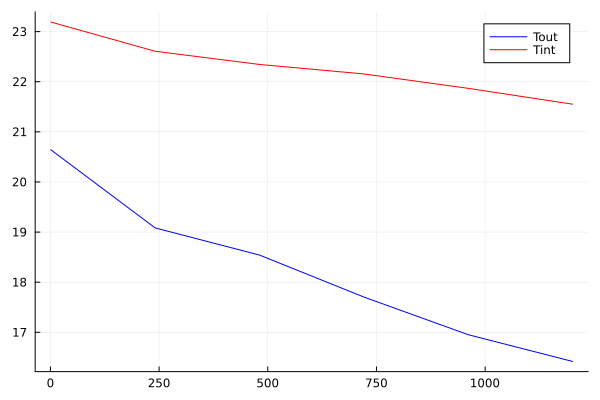

In [3]:
Plots.plot(vec(Tout), label="Tout", linecolor="blue")
Plots.plot!(vec(TintRec), label="Tint", linecolor="red")
# plot!(timing/3600, E_int*ones(length(timing)), label="E_int", linecolor="green")
# plot!(plot_title="E")

In [4]:
# definining constants again, just for completeness and avoid issues..
va      = 2880;     # Volume of air inside the building [m^3]
rhoa    = 1.225;     # Density of air [kg/m^3]
ca      = 1005;      # Specific heat of air [J/KgK]
th      = 0.1;       # Thickness of thermal mass floors[m]
A_f     = 2*90;       # Area of the 3 floors [m^2]
rho_f   = 2300;     # Density of Thermal Mass concrete [kg/m^3]
k_f     = 0.8;         # Conductivity of Thermal Mass concrete [W/mK]
c_f     = 750;        # Specific heat of Thermal Mass concrete [J/KgK]
hconv   = 4;           # Convective heat coefficient [W/m2.K]
Eint    = 250;      # Internal loads due to occupancy, lighting and equipment [W]

## Fabric calculation 

In [5]:
# Discretization variables
dt = 15;
dx = th/10;
x = range(0, th, step = dx)  |> collect 
Nx = length(x)

11

In [6]:
function conductionMatrix(lambda, dt, dx, Nx)
    # used to calculate temperature evolution within a fabric 
    A = zeros(Nx, Nx)

    A[1,1] = 1-lambda;  
    A[1,2] = lambda;
    A[Nx,Nx-1] = lambda;
    A[Nx,Nx] = 1-lambda;  
    
    # all other rows 
    for i = 2:Nx-1
        A[i, i-1] = lambda;
        A[i, i] = 1-2*lambda;
        A[i, i+1] = lambda;
    end

    return A

end

function cd_pivot(alpha)
    "calculate discharge coefficient based on window opening angle"
    W=1;
    H=1;
    W_pivot = z -> (1/W^2 + 1/(2*(H-z)*tand(alpha)+sind(alpha)*W).^2) .^(-1/2)
    h = H * (1- cosd(alpha));
    integral, est = quadgk(W_pivot,h,H) #rtol=1e-8 -> error when go to last element of angle array
    A_eff = W*h + integral ;
    Cd0 = 0.611;
    Cd = A_eff / (H*W) * Cd0;   
    
end

cd_pivot (generic function with 1 method)

In [7]:
# Matrix for conduction 
alpha = k_f/(rho_f*c_f) # thermal conductivity / (density * specific heat )
lambda = alpha * dt / dx^2
A = conductionMatrix(lambda, dt, dx, Nx);


### initialize data structures for fabric calculation 

In [8]:
# initialize night flush conditions => convert from clecius to kelvin 
err = 1e-2
Tint = 273 .+TintRec; 
T0 = 273 .+TintRec;
# added error terms so that Tf[1,t] - Tint[t], but this is an intermediate solution 
TNx = 273 + err .+TintRec; 
Tf = T0 .+ (TNx-T0).* (x .+ err)/th
Tf

11×1201 Matrix{Float64}:
 296.193  296.191  296.188  296.186  …  294.557  294.556  294.555  294.553
 296.194  296.192  296.189  296.187     294.558  294.557  294.556  294.554
 296.195  296.193  296.19   296.188     294.559  294.558  294.557  294.555
 296.196  296.194  296.191  296.189     294.56   294.559  294.558  294.556
 296.197  296.195  296.192  296.19      294.561  294.56   294.559  294.557
 296.198  296.196  296.193  296.191  …  294.562  294.561  294.56   294.558
 296.199  296.197  296.194  296.192     294.563  294.562  294.561  294.559
 296.2    296.198  296.195  296.193     294.564  294.563  294.562  294.56
 296.201  296.199  296.196  296.194     294.565  294.564  294.563  294.561
 296.202  296.2    296.197  296.195     294.566  294.565  294.564  294.562
 296.203  296.201  296.198  296.196  …  294.567  294.566  294.565  294.563

In [9]:
t=2
Tf[1,t] - Tint[t]

0.0009999999999763531

## natural ventilation 

In [10]:
g = 9.81;

### windows

In [12]:
# window properties 
w1 = Dict("alpha" => 42, "area" => 1.61, "l" => 11.34)
w1["cd"] = cd_pivot(w1["alpha"])

w2 = Dict("alpha" => 42, "area" => 1.755, "l" => 6.62)
w2["cd"] = cd_pivot(w2["alpha"])

w3 = Dict("alpha" => 42, "area" => 1.755, "l" => 2.07)
w3["cd"] = cd_pivot(w3["alpha"]);

In [13]:
# convert data into kelvin 
time_in_seconds = time*3600;
time_in_hours   = time;
Tout        = 273 .+Tout;
TintReal    = 273 .+TintRec;

## recursive loop - compute ventilation, internal temperature, and fabric temperature..

In [14]:
Q1 = zeros(length(time));
Q2 = zeros(length(time));
Q3 = zeros(length(time));
Q_tot = zeros(length(time));
Env = zeros(length(time));
qconvst = zeros(length(time));
b = zeros(1,Nx)
Eist = zeros(length(time));

In [15]:
print("hi")

hi

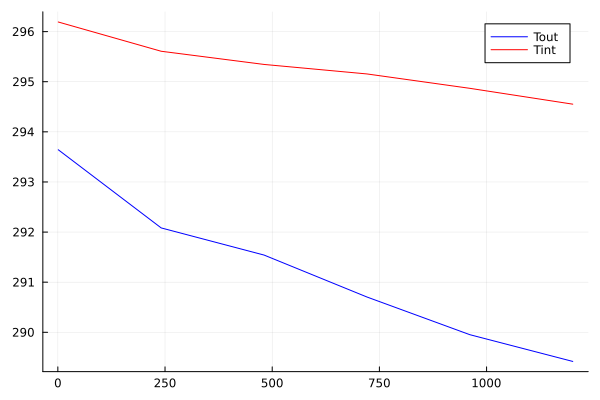

In [16]:
Plots.plot(vec(Tout), label="Tout", linecolor="blue")
Plots.plot!(vec(Tint), label="Tint", linecolor="red")

In [17]:
for t=1:length(time)-1
    # equivalent hour 
    h = time_in_hours[t];
    # print("$t")
    # calculate energy of nat vent at each time step... 
    #Q = \dot{V} => rate of change of volume 
    for (w, Q) in zip([w1, w2, w3], [Q1, Q2, Q3]) 
        # print("$(Tint[t]-Tout[t]) \n")
        Q[t] = w["cd"] * w["area"] * sqrt(2*g*w["l"] * (Tint[t]-Tout[t]) /(Tout[t]))
    end
    # print("hi $t, $(Q_tot[t]) \n")
    Q_tot[t] = Q1[t] + Q2[t] + Q3[t]
    # print("t = $t \n Tout length = $(length(Tout)) \n Tint length = $(length(Tint))\n ")
    Env[t] = rhoa * ca * Q_tot[t] * (Tout[t] - Tint[t])


    # convective heat flux
    qconv = hconv* (Tf[1,t] - Tint[t]) 
    qconvst[t] = qconv


    # # wall boundary conditions 
    b[1] = - lambda * dx / (k_f * qconv)
    b[Nx] = - lambda * dx / (k_f * qconv)

    # # thermal mass temperature 
    Tf[:, t+1] = A*Tf[:,t] + b'

    # TODO work out the math thats happening here...

    # # Air temperature
    Tint[t + 1] = Tint[t] + (qconv*6*A_f + Eint + Env[t])*dt/(va*rhoa*ca)
    Eist[t] = Eint


 end

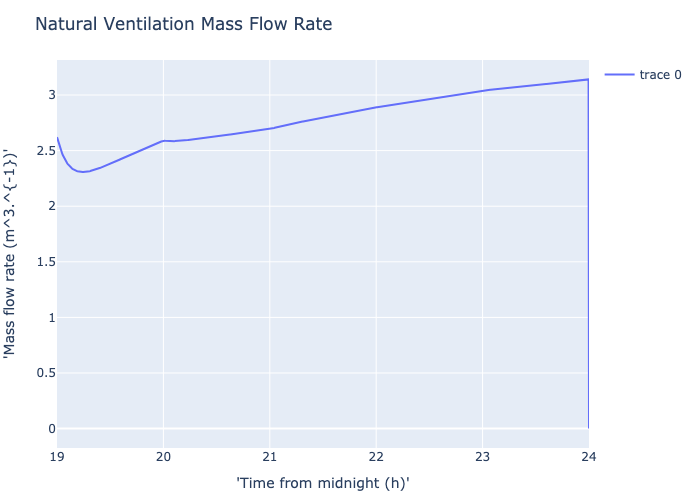

In [18]:
Vnvtot = Q_tot;
t1 = PlotlyJS.scatter(x=vec(time_in_hours),  y=vec(Vnvtot ), mode="lines")
p1 = PlotlyJS.plot([t1],   config=PlotConfig(scrollZoom=false), Layout(;title="Natural Ventilation Mass Flow Rate", showlegend=true, xaxis_title="'Time from midnight (h)'", yaxis_title="'Mass flow rate (m^3.^{-1})'"));
p1

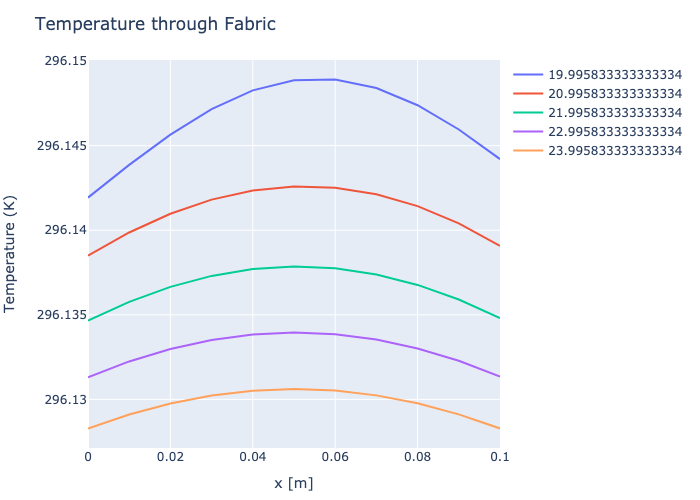

In [19]:
time = ["'12 pm'", "'4 pm'", "'12 am'", "'4 am'", "'8 am'"];
traces = [PlotlyJS.scatter(x=x,  y=Tf[:, 4*60*i], mode="lines", name=time_in_hours[4*60*i]) for i in 1:5];
p3 = PlotlyJS.plot(traces, Layout(;title="Temperature through Fabric", showlegend=true, xaxis_title="x [m]", yaxis_title="Temperature (K)" ),  config=PlotConfig(scrollZoom=false));
p3

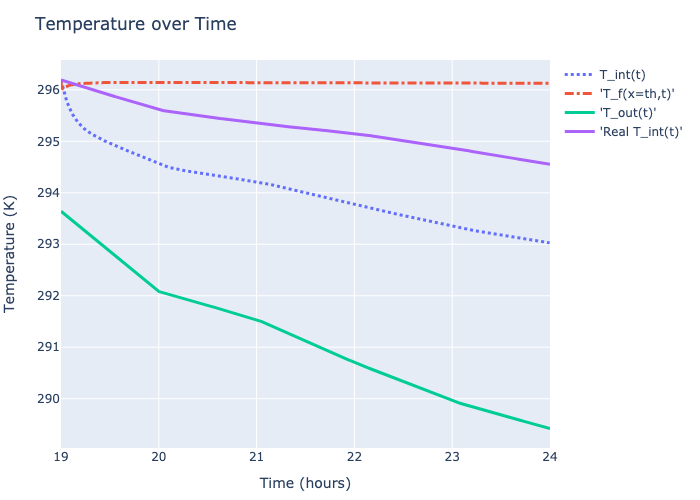

In [20]:
labels = ["T_int(t)","'T_f(x=th,t)'","'T_out(t)'","'Real T_int(t)'"];
vals = [Tint[1:end-1], Tf[end, 1:end-1], vec(Tout), vec(TintReal)]
linewidths = [3,3,3,3]
dashtypes = ["dot", "dashdot", "none", "none"]


traces = [PlotlyJS.scatter(x=vec(time_in_hours),  y=val, mode="lines", name=label, line=attr(width=lw, dash=dt)) for (val,label, lw, dt) in zip(vals, labels, linewidths, dashtypes)];


p3 = PlotlyJS.plot(traces, Layout(;title="Temperature over Time", showlegend=true, xaxis_title="Time (hours)", yaxis_title="Temperature (K)" ),  config=PlotConfig(scrollZoom=false));
p3